# Employment by sector and departement

In [1]:
from pynsee.localdata import get_local_metadata, get_nivgeo_list, get_local_data
from pynsee.geodata import get_geodata
from pynsee.metadata import get_activity_list
from shapely import wkt

import pandas as pd
from pandas.api.types import CategoricalDtype
import geopandas as gpd
import seaborn as sns
import math

from matplotlib.pyplot import pie
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# get a list all data available : datasets and variables
metadata = get_local_metadata()

# geographic metadata
nivgeo = get_nivgeo_list()

In [2]:
# get departement map
dep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')

dep = dep.translate(departement=['971', '972', '974', '973', '976'],
                   factor=[1.5, 1.5, 1.5, 0.3, 1.5])

dep = dep.zoom(factor = 3.5 , startAngle = math.pi * (1 - 3 * 1/9))

dep = dep[["insee_dep", "geometry"]]
dep = dep.rename(columns={'insee_dep': 'CODEGEO'})

In [3]:
# get local data from INSEE API
data = get_local_data(dataset_version = 'GEO2020FLORES2017',
                     variables =  'NA17',
                     nivgeo = 'DEP')
data = data.rename(columns={'NA17': 'A17'})

Existing environment variables used, instead of locally saved credentials
Getting data: 100%|██████████| 101/101 [01:21<00:00,  1.23it/s]      


In [4]:
# keep only headcounts and remove the total from the data
df = data[data["UNIT"] == "NBSALET"].reset_index(drop=True)
df = df[~df["A17"].isin(["ENS"])].reset_index(drop=True)

In [5]:
# compute share of activity in total employment by department
df['employment_share'] = 100 * df["OBS_VALUE"] / df['OBS_VALUE'].groupby(df['CODEGEO']).transform('sum')

In [6]:
# merge values and geographic limits
datamap = df.merge(dep, how = 'left', on = 'CODEGEO')
datamap = gpd.GeoDataFrame(datamap)

In [7]:
# add english activity labels at A17 level
activity = get_activity_list("A17")
activity["TITLE_A17_EN"] = activity["A17"] + " - " + activity["TITLE_A17_EN"]
datamap = datamap.merge(activity, how='left', on='A17')

In [8]:
# compute center location for each departement
def get_center(x):
    return x.centroid.wkt

datamap["center"] = datamap['geometry'].apply(lambda x: get_center(x))

# list of departements
list_dep = datamap["CODEGEO"].unique()

In [9]:
# make color palette
colors = sns.color_palette("Set1") + sns.color_palette("Set2")

# order activity sectors according to average share
emplTot = datamap[["employment_share", "TITLE_A17_EN"]].groupby(['TITLE_A17_EN'], observed=True).mean()
emplTot = emplTot.sort_values(by=["employment_share"],  ascending=False)

datamap["TITLE_A17_EN"] = datamap["TITLE_A17_EN"].astype(CategoricalDtype(categories=emplTot.index, ordered=True))
datamap = datamap.sort_values(["TITLE_A17_EN"]).reset_index(drop=True)
datamap

,CODEGEO,NIVGEO,UNIT,UNIT_label_fr,A17,OBS_VALUE,NA17_label,DATASET_VERSION,DATASET_NAME,DATA_DATE,GEO_DATE,CODEGEO_label,employment_share,geometry,A5,A10,TITLE_A17_EN,TITLE_A17_FR,center
0,24,DEP,NBSALET,Postes salariés dans les établissements,OQ,47091,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Dordogne,39.785237,"MULTIPOLYGON (((4538.510 5624971.758, 4634.387...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (82503.88583124451 5638329.410666983)
1,33,DEP,NBSALET,Postes salariés dans les établissements,OQ,199158,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Gironde,32.943017,"MULTIPOLYGON (((-128762.061 5717199.240, -1287...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-64206.77633210372 5594297.759162161)
2,71,DEP,NBSALET,Postes salariés dans les établissements,OQ,61315,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Saône-et-Loire,34.317841,"MULTIPOLYGON (((531046.916 5928690.377, 531251...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (505725.92242259247 5884496.094662105)
3,01,DEP,NBSALET,Postes salariés dans les établissements,OQ,54202,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Ain,29.047782,"MULTIPOLYGON (((533820.757 5815685.538, 533972...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (595403.9693304703 5796511.958803039)
4,22,DEP,NBSALET,Postes salariés dans les établissements,OQ,66843,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Côtes-d'Armor,36.247933,"MULTIPOLYGON (((-382905.380 6257752.911, -3828...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-318942.6429392173 6180631.785546785)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,13,DEP,NBSALET,Postes salariés dans les établissements,C2,1446,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Bouches-du-Rhône,0.182878,"MULTIPOLYGON (((597782.742 5338896.723, 597787...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (566095.8521214168 5395484.572187278)
1764,26,DEP,NBSALET,Postes salariés dans les établissements,C2,0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Drôme,0.0,"MULTIPOLYGON (((540386.992 5605296.851, 540431...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (575197.8809542124 5572442.056683063)
1765,59,DEP,NBSALET,Postes salariés dans les établissements,C2,269,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Nord,0.027313,"MULTIPOLYGON (((338476.314 6474007.637, 339089...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (357483.2519709124 6524765.489153067)
1766,27,DEP,NBSALET,Postes salariés dans les établissements,C2,0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Eure,0.0,"MULTIPOLYGON (((35180.302 6327852.729, 34839.6...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (110910.78782311625 6294369.484342183)


In [10]:
emplTot

,employment_share
TITLE_A17_EN,
"OQ - Public administration and defence, education, human health and social work activities",36.017645
GZ - Wholesale and retail trade; repair of motor vehicles and motorcycles,13.79726
"MN - Professional, scientific, technical, administrative and support service activities",9.349464
C5 - Other manufacturing,6.822302
FZ - Construction,6.040776
HZ - Transportation and storage,5.366087
IZ - Accommodation and food service activities,4.07249
RU - Other services activities,3.733203
"C1 - Manufacture of food products, beverages and tobacco products",3.016751


In [11]:
# draw plot

def extract_lon(x):
    return wkt.loads(x).xy[0][0]
def extract_lat(x):
    return wkt.loads(x).xy[1][0]

ax = datamap.plot(color='white', edgecolor='black', figsize = (15,15))

ax_sub_coeff = 80000

for idep in list_dep:
    
    df = datamap[datamap["CODEGEO"] == idep].reset_index(drop=True)
    df["lon"] = df["center"].apply(lambda x: extract_lon(x))
    df["lat"] = df["center"].apply(lambda x: extract_lat(x))

    df = df[df["lon"] == min(df["lon"])].reset_index(drop=True)
    center = df.loc[0,"lon"], df.loc[0,"lat"]

    ratios = df["employment_share"]

    ax_sub = ax.inset_axes(
                    bounds=(center[0]-ax_sub_coeff/2,
                            center[1]-ax_sub_coeff/2, 
                            ax_sub_coeff, ax_sub_coeff),
                    transform=ax.transData
                   )
    
    ax_sub.pie(ratios, wedgeprops={'edgecolor': 'gray','linewidth': 0.25}, colors = colors)
    

plt.suptitle('Employment by sector and departement', x = 0.4, y = 0.85,
            horizontalalignment= 'left',
            fontsize = 12, fontweight='bold')
plt.legend(emplTot.index, loc="lower left", bbox_to_anchor=(-27, -9), ncol=2)
plt.savefig('empl_map_fr.png')
plt.close()

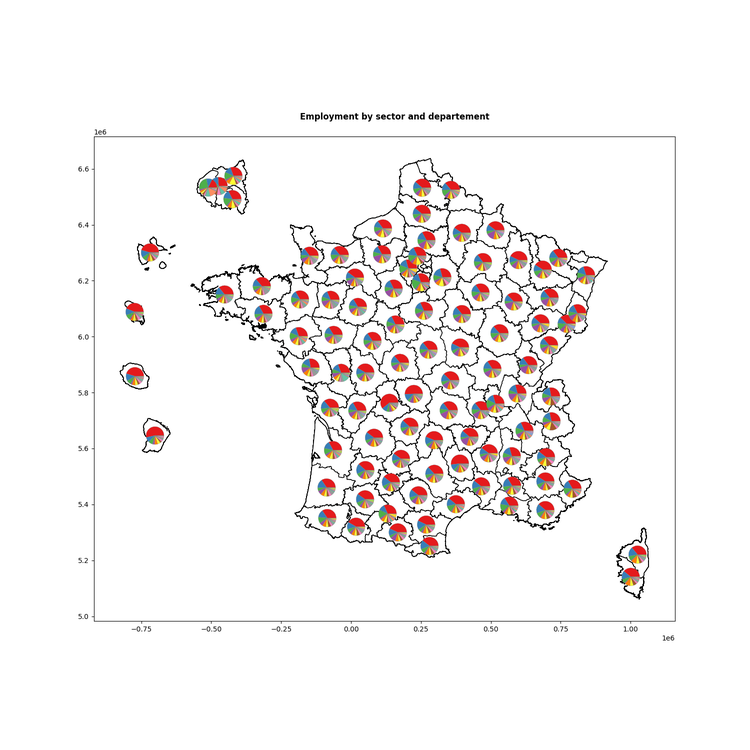

In [12]:
from PIL import Image 
def resize_pix(img, pct):
    hsize = int((float(img.size[1])*float(pct)))
    wsize = int((float(img.size[0])*float(pct)))
    img = img.resize((wsize,hsize), Image.Resampling.LANCZOS)
    return img
    
img = Image.open('empl_map_fr.png').convert("RGB")
img = resize_pix(img, pct=0.5)
img